In [1]:
# modelagem e dados
import torch
from torch import nn, optim

# plotting e visualização
from torchsummary import summary
import matplotlib.pyplot as plt

# operações de imagem
import cv2

# outros
import os
import numpy as np
from tqdm import tqdm

In [2]:
from model.model_encoder_bilinear import SegNet
from dataset.dataloader_sun_rgbd import train_loader, val_loader, test_loader


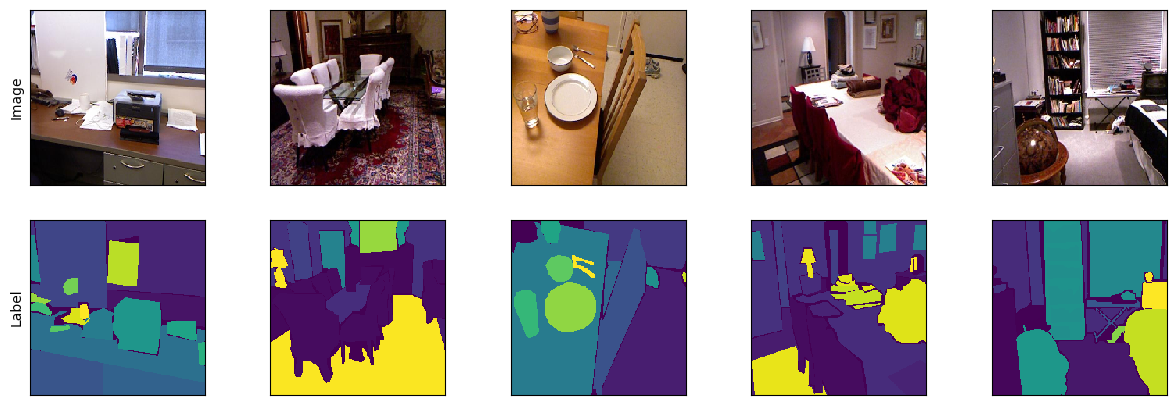

In [3]:
w = 5
fig, ax = plt.subplots(2, w, figsize=(15, 5))

ax[0][0].set_ylabel("Image")
ax[1][0].set_ylabel("Label")

for j in range(w):
    instances, targets = next(iter(train_loader))
    ax[0][j].imshow(instances[0].permute(1, 2, 0).numpy().astype("uint8"), cmap="gray", interpolation="None")
    ax[0][j].set_xticks([])
    ax[0][j].set_yticks([])

    ax[1][j].imshow((torch.argmax(targets[0].permute(1, 2, 0), dim=2)).numpy().astype("uint8"), interpolation="None")
    ax[1][j].set_xticks([])
    ax[1][j].set_yticks([])

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [5]:
model = SegNet(output_size=256).to(device)
# model.load_state_dict(torch.load(r"model\weights\best_pretrained_bilinear.zip"))
summary(SegNet().to(device), (3, 224, 224), 1, device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 224, 224]           1,792
            Conv2d-2          [1, 64, 224, 224]           1,792
              ReLU-3          [1, 64, 224, 224]               0
       BatchNorm2d-4          [1, 64, 224, 224]             128
            Conv2d-5          [1, 64, 224, 224]          36,928
            Conv2d-6          [1, 64, 224, 224]          36,928
              ReLU-7          [1, 64, 224, 224]               0
       BatchNorm2d-8          [1, 64, 224, 224]             128
         MaxPool2d-9          [1, 64, 112, 112]               0
           Conv2d-10         [1, 128, 112, 112]          73,856
           Conv2d-11         [1, 128, 112, 112]          73,856
             ReLU-12         [1, 128, 112, 112]               0
      BatchNorm2d-13         [1, 128, 112, 112]             256
           Conv2d-14         [1, 128, 1

In [6]:
train_losses = list()
valid_losses = list()

In [7]:
EPOCHS = 25
lr = 0.01
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

In [8]:
def train_step(model, loader, loss_fn, optimizer, device) -> float:
  train_loss = 0
  for X, Y in loader:
    y_pred = model(X.to(device))
    loss = loss_fn(y_pred, Y.to(device))
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  return train_loss / len(loader)


def validation_step(model, loader, loss_fn, device) -> float:
  loss = 0
  with torch.no_grad():
    for X, Y in loader:
      y_pred = model(X.to(device))
      loss += loss_fn(y_pred, Y.to(device)).item()
  return loss / len(loader)

In [9]:
from tqdm import tqdm
from copy import deepcopy

def train_model():
  for epoch in tqdm(range(EPOCHS)):
    train_losses.append(train_step(model, train_loader, loss_fn, optimizer, device))
    valid_losses.append(validation_step(model, val_loader, loss_fn, device))
    if valid_losses[-1] == min(valid_losses):
      best_model = deepcopy(model)
    print("\fLoss: {}\n".format(valid_losses[-1]))
  return best_model

In [10]:
model.freeze_encoder_block()
best_model = train_model()

  0%|          | 0/25 [00:04<?, ?it/s]


KeyboardInterrupt: 

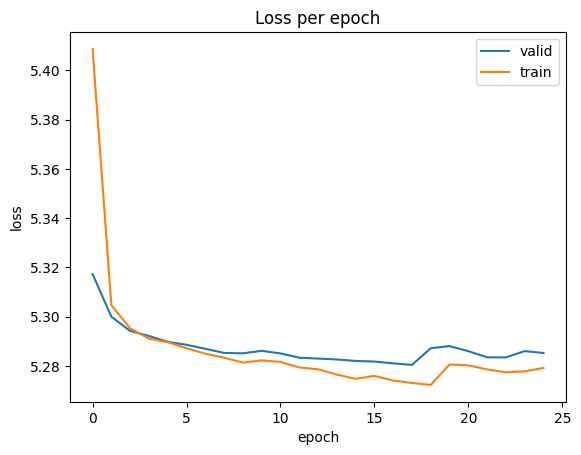

In [ ]:
def plot_loss(loss_train, loss_valid):
  plt.plot(loss_valid, label='valid')
  plt.plot(loss_train, label='train')
  plt.title('Loss per epoch')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend()
  plt.show()

plot_loss(train_losses, valid_losses)

In [ ]:
model.unfreeze_encoder_block()
best_model = train_model()

  4%|▍         | 1/25 [03:44<1:29:47, 224.49s/it]

Loss: 5.283390092849731



  8%|▊         | 2/25 [07:29<1:26:11, 224.84s/it]

Loss: 5.28205174446106



 12%|█▏        | 3/25 [11:14<1:22:24, 224.77s/it]

Loss: 5.281014240582784



 16%|█▌        | 4/25 [14:59<1:18:41, 224.82s/it]

Loss: 5.2816837771733605



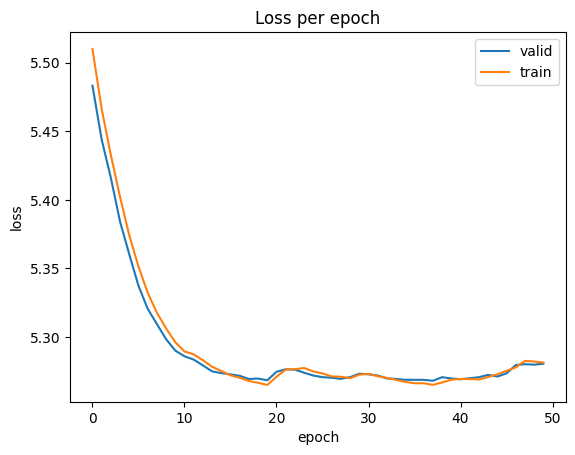

In [ ]:
def plot_loss(loss_train, loss_valid):
  plt.plot(loss_valid, label='valid')
  plt.plot(loss_train, label='train')
  plt.title('Loss per epoch')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend()
  plt.show()

plot_loss(train_losses, valid_losses)

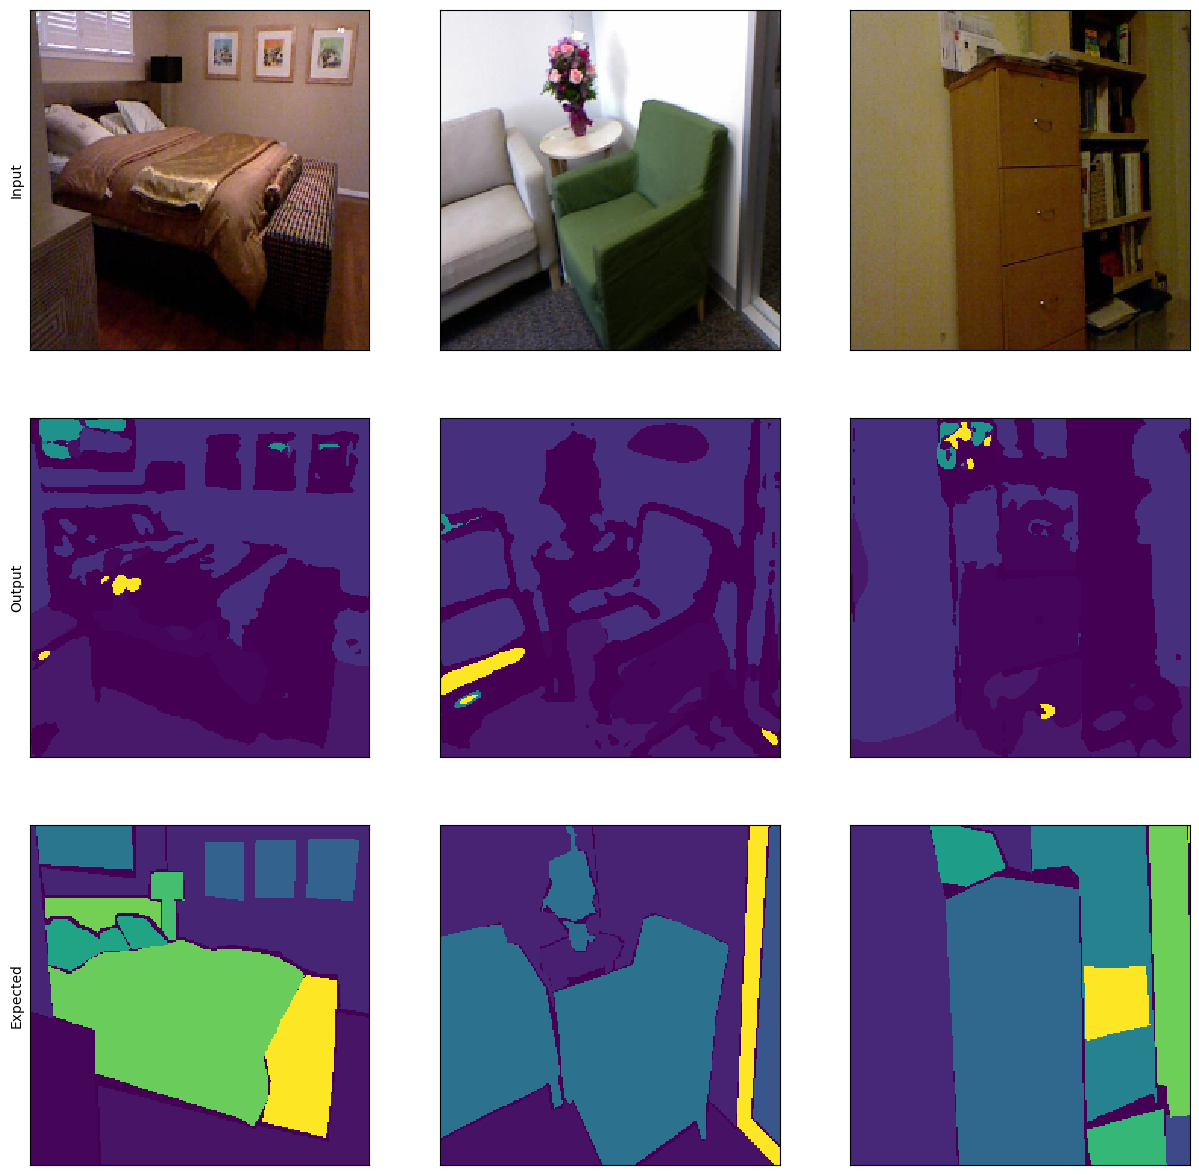

In [ ]:
w = 3
fig, ax = plt.subplots(3, w, figsize=(15, 15))

ax[0][0].set_ylabel("Input")
ax[1][0].set_ylabel("Output")
ax[2][0].set_ylabel("Expected")
with torch.no_grad():
    for j in range(w):
        instances, targets = next(iter(test_loader))
        ax[0][j].imshow(instances[0].permute(1, 2, 0).numpy().astype("uint8"), cmap="gray", interpolation="None")
        ax[0][j].set_xticks([])
        ax[0][j].set_yticks([])

        ax[1][j].imshow(torch.argmax(model(instances[0].to(device).unsqueeze(0)).squeeze(0).permute(1, 2, 0), dim=2).cpu().numpy().astype("uint8"), interpolation="None")
        ax[1][j].set_xticks([])
        ax[1][j].set_yticks([])

        ax[2][j].imshow((torch.argmax(targets[0].permute(1, 2, 0), dim=2)).numpy().astype("uint8"), interpolation="None")
        ax[2][j].set_xticks([])
        ax[2][j].set_yticks([])

In [11]:
from utils.evaluation.multi_channel_iou import IoU
iou = IoU().to(device)

In [12]:
iou_test = torch.zeros([1, 258]).to(device)

for instances, targets in test_loader:
    predict = torch.zeros(targets.shape).to(device)
    res = torch.argmax(model(instances.to(device)), dim=-3)
    for ch in range(targets.shape[1]):
        predict[:, ch, :, :] = (res == ch)
    iou_test += iou(predict, targets.to(device))

iou_test /= len(test_loader)
iou_test

tensor([[8.6693e-01, 3.1142e-02, 7.4341e-02, 2.5697e-02, 2.0217e-02, 2.5070e-02,
         1.0844e-02, 2.0066e-02, 6.7980e-01, 6.2420e-03, 7.2007e-04, 5.8128e-01,
         7.2414e-01, 2.5330e-02, 6.6995e-01, 7.5369e-01, 8.1773e-01, 1.2379e-02,
         8.8177e-01, 8.0296e-01, 8.5714e-01, 5.8132e-03, 7.5862e-01, 4.8726e-02,
         1.2321e-01, 9.1626e-01, 1.9838e-02, 9.3596e-01, 7.6355e-01, 9.3596e-01,
         1.0061e-02, 9.7044e-01, 9.7044e-01, 9.7537e-01, 9.1626e-01, 9.8030e-01,
         9.7537e-01, 9.2118e-01, 6.9459e-01, 9.8030e-01, 0.0000e+00, 9.6059e-01,
         9.9507e-01, 9.7044e-01, 3.7844e-03, 9.9015e-01, 9.8030e-01, 9.6059e-01,
         9.6552e-01, 9.7044e-01, 9.8522e-01, 9.2611e-01, 9.9507e-01, 9.7537e-01,
         1.0000e+00, 9.9507e-01, 9.8030e-01, 6.6010e-01, 9.0148e-01, 9.9507e-01,
         9.8030e-01, 8.1773e-01, 9.9015e-01, 9.8522e-01, 9.5074e-01, 1.0000e+00,
         1.1650e-03, 9.9507e-01, 9.4581e-01, 9.7044e-01, 9.9507e-01, 9.9015e-01,
         9.6059e-01, 9.7537e

In [ ]:
iou_test[0, 1]

tensor(117.4453, device='cuda:0')

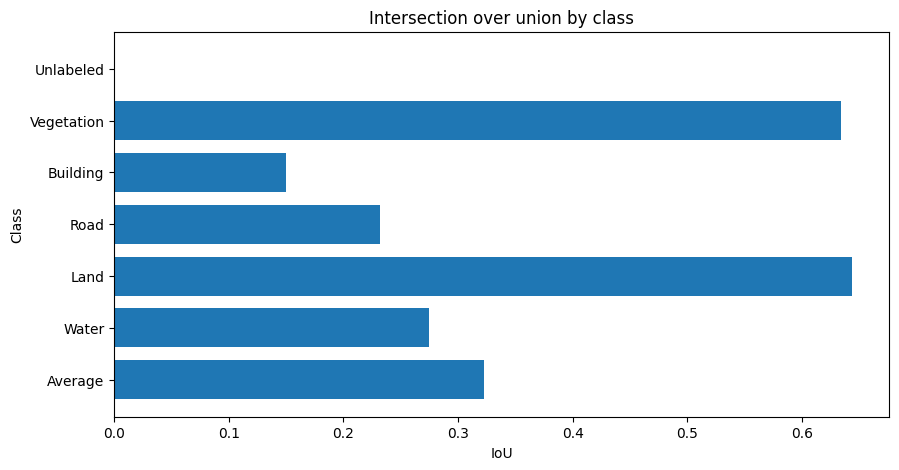

In [ ]:
classes = ["Average", "Water", "Land", "Road", "Building", "Vegetation", "Unlabeled"]
values = list(iou_test.squeeze().cpu().numpy())

fig = plt.figure(figsize = (10, 5))

plt.barh(classes, values, height=0.75)
 
plt.xlabel("IoU")
plt.ylabel("Class")
plt.title("Intersection over union by class")
plt.show()

In [ ]:
to_save = True

if to_save:
    torch.save(model.state_dict(), r"model\weights\best_pretrained_bilinear_sun.zip")